# Lyrics project

## Dependencies and Data Acquisition

Next cell is accumulating all the dependencies this notebook is requiring.

In [197]:
import re
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

nltk.download('punkt')
nltk.download("stopwords")

from wordcloud import WordCloud
from nltk.stem import SnowballStemmer
from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, KFold, cross_validate, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.pipeline import make_pipeline
from sklearn.metrics import plot_confusion_matrix

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pivanov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pivanov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The data for this notebook is provided from [Ilia Chernov's scrapper script](https://colab.research.google.com/drive/1SwLlAGW6E_4SSzxjjJSFjDy6TsZoG-QY?usp=sharing).
The data is in form of JSON text file.

In [2]:
df = pd.read_json("./data/songs_lyrics.json").reset_index(drop=True)

df

,album_name,album_year,song_name,song_id,song_link,artist,song_text
0,"Extreme Metal 101, Vol. 1",2013.0,Lunatic of God's Creation,31255335,/lyric/31255335/Deicide/Lunatic+of+God%27s+Cre...,Deicide,"Servants of death, enchanter of pain\nFrom the..."
1,"Extreme Metal 101, Vol. 1",2013.0,Sacrificial Suicide,31255334,/lyric/31255334/Deicide/Sacrificial+Suicide,Deicide,"Satanized, crucified, feel the wrath of suicid..."
2,"Extreme Metal 101, Vol. 1",2013.0,Oblivious to Evil,31255333,/lyric/31255333/Deicide/Oblivious+to+Evil,Deicide,Join us\n\nEvil night of an evil death\nEpitom...
3,"Extreme Metal 101, Vol. 1",2013.0,Dead by Dawn,31255332,/lyric/31255332/Deicide/Dead+by+Dawn,Deicide,"Book of the dead, pages bound in human flesh\n..."
4,"Extreme Metal 101, Vol. 1",2013.0,Blaspherereion,31255331,/lyric/31255331/Deicide/Blaspherereion,Deicide,"Bleeding death, undead, broke the seal suhrim\..."
...,...,...,...,...,...,...,...
1207,Unknown Album,NaN,Who Wants To Live Forever,37872255,/lyric/37872255/Queen/Who+Wants+To+Live+Forever,Queen,There's no time for us\nThere's no place for u...
1208,Unknown Album,NaN,The Show Must Go On [Live at The O2],37604633,/lyric/37604633/Queen/The+Show+Must+Go+On+%5BL...,Queen,"Empty spaces, what are we living for?\nAbandon..."
1209,Unknown Album,NaN,"Love Of My Life [Live at Rock in Rio Festival,...",35536594,/lyric/35536594/Queen/Love+Of+My+Life+%5BLive+...,Queen,"Love of my life, you've hurt me\nYou've broken..."
1210,Unknown Album,NaN,You Are The Champions,37083371,/lyric/37083371/Queen/You+Are+The+Champions,Queen,I've paid my dues\nTime after time\nI've done ...


## Making the dataframe balanced

Following code will balance the classes in the data set as requested by the task description.

Counting song by all artists. We can see _Deicide_ has least amount of songs (91).

In [3]:
df["artist"].value_counts()

Eminem           576
Queen            310
Justin-Bieber    235
Deicide           91
Name: artist, dtype: int64

By running this code below we'll append each artists first 91 songs.

In [6]:
# Creating balanced DataFrame
df_balanced = pd.DataFrame()

# Getting all unique artist names
artists = df["artist"].unique()

# Computing which artist does have lowest count of available lyrics
artist_min = df["artist"].value_counts().min()

# Getting the first <artist_min> rows from all artists into balanced DataFrame
df_balanced = df_balanced.append(
    [
        df.loc[df["artist"]==artist].iloc[0:artist_min]
        for artist in artists
        ]
    )

Check if everything went well:

In [7]:
df_balanced["artist"].value_counts()

Queen            91
Deicide          91
Justin-Bieber    91
Eminem           91
Name: artist, dtype: int64

## Tokenization, lowercase and punctuation removal

To help out with tokenization, conversion to lowercase and removing of punctuation we'll define functions to perform these individual tasks:
 * Tokenization is done by NLTK `word_tokenize()` function
 * For punctuation removal, we're using _regex_ to filter out words that are made up from non-alphabetical characters.  
   `pattern = "^\W+$"`
 * Conversion to lowercase is done via `str.lower()` function.
 * Removal of stopwords is done using list comprehension. Stopwords used are taken from NLTK _stopwords_ corpus.

In [8]:
# Function that takes a _list of strings_ and removes all punctuation words.
# Punctuation is defined via Regex as "^\W+$"
def remove_punct(list_of_words):
    result = [word for word in list_of_words if not(re.match("^\W+$", word))]
    return result

# Simple lowercase conversion
def to_lowercase(list_of_words):
    result = [word.lower() for word in list_of_words]
    return result

# Removal of stopwords using _stopwords_ corpus provided by NLTK
def remove_stopwords(list_of_words):
    result = [word for word in list_of_words if word not in nltk.corpus.stopwords.words("english")]
    return result

Application of all steps now looks tidy:

In [9]:
df_balanced["song_ready"] = (df_balanced["song_text"]
                             .apply(nltk.word_tokenize)
                             .apply(remove_punct)
                             .apply(to_lowercase)
                             .apply(remove_stopwords))

Check whether the result is what we expected:

In [10]:
df_balanced[["song_text", "song_ready"]]

,song_text,song_ready
0,"Servants of death, enchanter of pain\nFrom the...","[servants, death, enchanter, pain, land, retur..."
1,"Satanized, crucified, feel the wrath of suicid...","[satanized, crucified, feel, wrath, suicide, i..."
2,Join us\n\nEvil night of an evil death\nEpitom...,"[join, us, evil, night, evil, death, epitome, ..."
3,"Book of the dead, pages bound in human flesh\n...","[book, dead, pages, bound, human, flesh, feast..."
4,"Bleeding death, undead, broke the seal suhrim\...","[bleeding, death, undead, broke, seal, suhrim,..."
...,...,...
988,"Ooh, ooh yeah, ooooh yeah\nGet your party gown...","[ooh, ooh, yeah, ooooh, yeah, get, party, gown..."
989,Ooh ooh ooh ooh\nOoh ooh\nOoh ooh ooh take it ...,"[ooh, ooh, ooh, ooh, ooh, ooh, ooh, ooh, ooh, ..."
990,You might believe in heaven\nI would not care ...,"[might, believe, heaven, would, care, say, eve..."
991,Bring out the charge of the love brigade\nTher...,"[bring, charge, love, brigade, spring, air, dr..."


## Stemming

We decided to use stemming to boost the feature importance of the individual word stems.

The operation is using `SnowballStemmer` component.

In [12]:
# Initializing english stemmer
stemmer = SnowballStemmer("english")

df_balanced["song_ready"] = (df_balanced["song_ready"]
                             .apply(lambda wordlist: [stemmer.stem(word) for word in wordlist]))

## Putting it all together

In the next step, we'll be using _CountVectorizer_ and that requires
a sequence of texts (songs) to be put in.

As we're having all tokens within any song in a _list_ now, this is not going
to work well with _CountVectorizer_.

We need to join the tokens back to form a single string for every song.

In [69]:
# Joining all words in _song_ready_ elements

# Hard way
# df_balanced["song_final"] = df_balanced["song_ready"].apply(lambda word_list: " ".join([word for word in word_list]))

# Fine way
df_balanced["song_final"] = df_balanced["song_ready"].str.join(" ")

# How to join all song into huge text
everything = df_balanced["song_final"].str.cat(sep=" ")

df_balanced

,album_name,album_year,song_name,song_id,song_link,artist,song_text,song_ready,song_final
0,"Extreme Metal 101, Vol. 1",2013.0,Lunatic of God's Creation,31255335,/lyric/31255335/Deicide/Lunatic+of+God%27s+Cre...,Deicide,"Servants of death, enchanter of pain\nFrom the...","[servant, death, enchant, pain, land, return, ...",servant death enchant pain land return ll kill...
1,"Extreme Metal 101, Vol. 1",2013.0,Sacrificial Suicide,31255334,/lyric/31255334/Deicide/Sacrificial+Suicide,Deicide,"Satanized, crucified, feel the wrath of suicid...","[satan, crucifi, feel, wrath, suicid, incus, f...",satan crucifi feel wrath suicid incus fear sph...
2,"Extreme Metal 101, Vol. 1",2013.0,Oblivious to Evil,31255333,/lyric/31255333/Deicide/Oblivious+to+Evil,Deicide,Join us\n\nEvil night of an evil death\nEpitom...,"[join, us, evil, night, evil, death, epitom, i...",join us evil night evil death epitom illus sac...
3,"Extreme Metal 101, Vol. 1",2013.0,Dead by Dawn,31255332,/lyric/31255332/Deicide/Dead+by+Dawn,Deicide,"Book of the dead, pages bound in human flesh\n...","[book, dead, page, bound, human, flesh, feast,...",book dead page bound human flesh feast beast b...
4,"Extreme Metal 101, Vol. 1",2013.0,Blaspherereion,31255331,/lyric/31255331/Deicide/Blaspherereion,Deicide,"Bleeding death, undead, broke the seal suhrim\...","[bleed, death, undead, broke, seal, suhrim, de...",bleed death undead broke seal suhrim desecr ev...
...,...,...,...,...,...,...,...,...,...
988,The Studio Collection,2015.0,Tie Your Mother Down,32103891,/lyric/32103891/Queen/Tie+Your+Mother+Down,Queen,"Ooh, ooh yeah, ooooh yeah\nGet your party gown...","[ooh, ooh, yeah, ooooh, yeah, get, parti, gown...",ooh ooh yeah ooooh yeah get parti gown get pig...
989,The Studio Collection,2015.0,You Take My Breath Away,32203557,/lyric/32203557/Queen/You+Take+My+Breath+Away,Queen,Ooh ooh ooh ooh\nOoh ooh\nOoh ooh ooh take it ...,"[ooh, ooh, ooh, ooh, ooh, ooh, ooh, ooh, ooh, ...",ooh ooh ooh ooh ooh ooh ooh ooh ooh take take ...
990,The Studio Collection,2015.0,Long Away,32203556,/lyric/32203556/Queen/Long+Away,Queen,You might believe in heaven\nI would not care ...,"[might, believ, heaven, would, care, say, ever...",might believ heaven would care say everi star ...
991,The Studio Collection,2015.0,The Millionaire Waltz,32203555,/lyric/32203555/Queen/The+Millionaire+Waltz,Queen,Bring out the charge of the love brigade\nTher...,"[bring, charg, love, brigad, spring, air, drin...",bring charg love brigad spring air drink sound...


## Frequency Distribution and Word Cloud

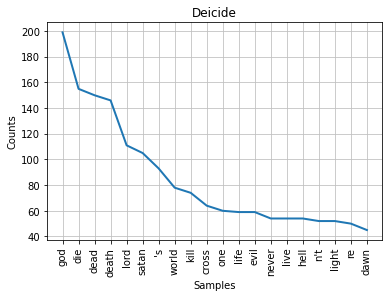

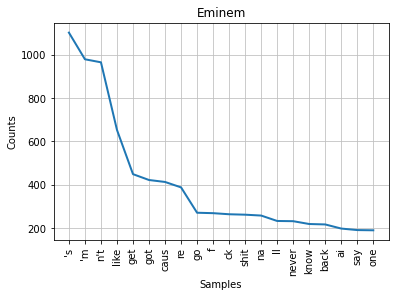

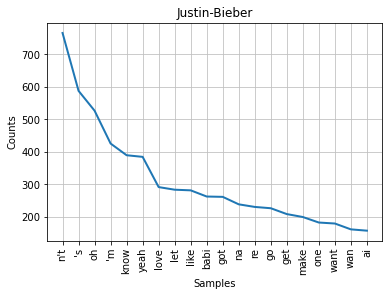

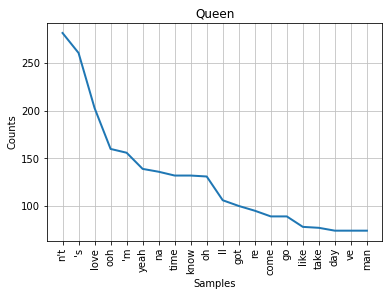

In [210]:
# I am wondering how frequency distributions look like for each artist

for artist in df_balanced["artist"].unique():
          
    alltext = [text for list_ in df_balanced.loc[df_balanced["artist"]==artist, "song_ready"].values for text in list_]
    
    #df_balanced.loc[df_balanced["artist"]==artist, "song_final"].apply
    
    #print(alltext)
    #print([word for word in alltext)
    fd = FreqDist([word for word in alltext])
    fd.plot(20, title=artist)

Seeing the plots for top 20 words in every artist, I was considering whether to clean words like:
 
 * _n't_
 * _'s_
 * _'m_
 * etc.
 
 
 But even though the plot curves look similar, the absolute numbers are distintive.  
 I.e. these short word forms are prevalent for e.g. _Eminem_ (hundreds in count), but for other
 artists they are less frequent (e.g. _Deicide_ counts them in tens).

Following word clouds we did just for fun.

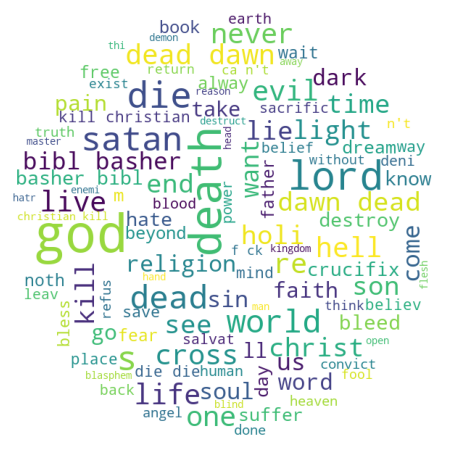

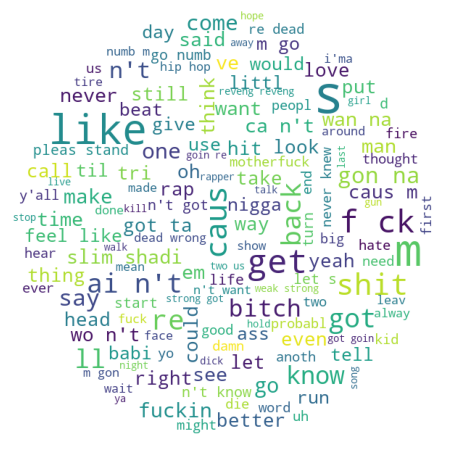

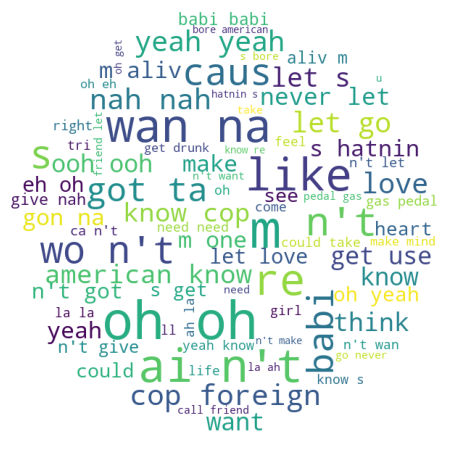

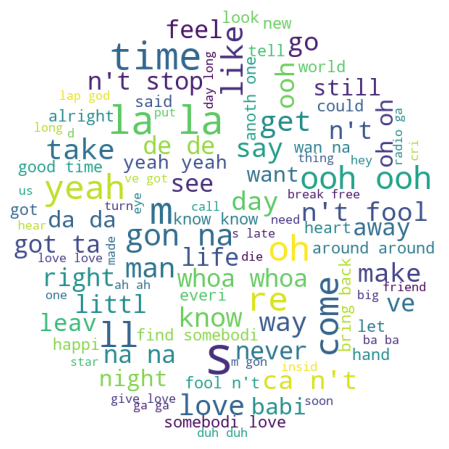

In [211]:
for artist in df_balanced["artist"].unique():
    
    alltext = " ".join([text for list_ in df_balanced.loc[df_balanced["artist"]==artist, "song_ready"].values for text in list_])
    
    x, y = np.ogrid[:600, :600]
    mask = (x - 300) ** 2 + (y - 300) ** 2 > 300 ** 2
    mask = 255 * mask.astype(int)
    
    wc = WordCloud(width=900, height=600, background_color="white", stopwords=[], min_font_size=14, max_font_size=72, mask=mask)
    wordcloud = wc.generate(alltext)
    
    plt.figure(figsize=(16, 8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

# Data sets preparation and split

We will be picking from following DataFrame columns:
 * song_ready = explaining variable
 * artist = target class

In [38]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 0 to 992
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   album_name  364 non-null    object 
 1   album_year  355 non-null    float64
 2   song_name   364 non-null    object 
 3   song_id     364 non-null    int64  
 4   song_link   364 non-null    object 
 5   artist      364 non-null    object 
 6   song_text   364 non-null    object 
 7   song_ready  364 non-null    object 
 8   song_final  364 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 28.4+ KB


So let's take _song_ready_ into $X$ and _artist_ into $y$

In [57]:
X = df_balanced["song_final"]
y = df_balanced["artist"]

Now we'll split the entire data set to:
 * train set (80%)
 * test set (20%)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(f"Train dataset: {X_train.shape}")
print(f"Test dataset : {X_test.shape}")

Train dataset: (291,)
Test dataset : (73,)


The stratification is not necessary as the datasets are artificially balanced, see the plot below:

<AxesSubplot:>

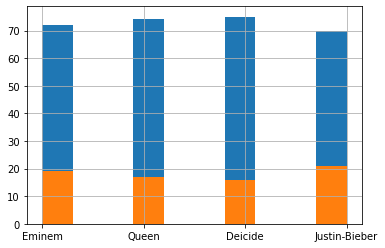

In [60]:
y_train.hist()
y_test.hist()

## Vectorization

We will prepare two types of vectorization:
1. _CountVectorizer_
2. _TfidfVectorizer_

In [86]:
# Creating "bag of words" using CountVectorizer
count_vectorizer = CountVectorizer()

bag_of_words = count_vectorizer.fit_transform(X_train)

In [87]:
bag_of_words.shape

(291, 6494)

In [89]:
tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(X_train)

In [90]:
tfidf_matrix.shape

(291, 6494)

# Training classification models

## Logistic Regression based on TFIDF Matrix

In [93]:
pipe = make_pipeline(TfidfVectorizer(), LogisticRegression())
pipe.fit(X_train, y_train)

cross_val_score(pipe, X_train, y_train).mean()

0.8692577440093512

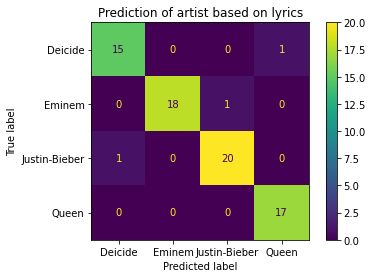

In [98]:
plot_confusion_matrix(pipe, X_test, y_test)
plt.title("Prediction of artist based on lyrics")
plt.show()

## Logistic Regression based on Count Vectorizer

In [101]:
pipe = make_pipeline(CountVectorizer(), LogisticRegression(max_iter=500))
pipe.fit(X_train, y_train)

cross_val_score(pipe, X_train, y_train).mean()

0.8452951490356517

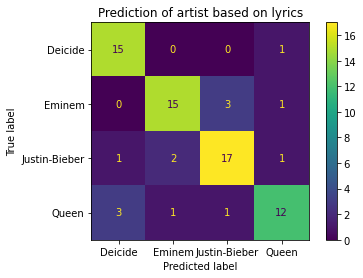

In [102]:
plot_confusion_matrix(pipe, X_test, y_test)
plt.title("Prediction of artist based on lyrics")
plt.show()

## Optimalization of hyper-parameters

I've chosen following classifiers with their parameter grids to run them through _GridSearchCV_:
* _LogisticRegression()_:
    ```
    "param_grid" : {
        "logisticregression__C"        : [1, 10, 100, 1000],
        "logisticregression__max_iter" : [1500],
        "logisticregression__solver"   : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
        }
    ```
* _KNeighborsClassifier()_:
    ```
    "param_grid" : {
        "kneighborsclassifier__n_neighbors" : [3, 5, 7, 11, 13],
        "kneighborsclassifier__weights"     : ["uniform", "distance"]
        }
    ```
* _SVC()_:
    ```
    "param_grid" : {
        "svc__C"            : [1, 10, 100, 1000],
        "svc__kernel"       : ["linear"],
        "svc__class_weight" : ["balanced"]
        }
    ```
* _GradientBoostingClassifier()_:
    ```
    "param_grid" : {
        "gradientboostingclassifier__n_estimators" : [100, 500],
        "gradientboostingclassifier__max_depth"    : [3, 5]
        }
    ```
* _RandomForestClassifier()_:
    ```
    "param_grid" : {
        "randomforestclassifier__n_estimators" : [100],
        "randomforestclassifier__max_depth"    : [3, 5, 7],
        "randomforestclassifier__criterion"    : ["gini", "entropy"]
        }
    ```

In [171]:
# Setting up a dictionary which will hold all setting for future loop over
dict_classifiers = {
    "Logreg": {
        "instantiate": LogisticRegression(),
        "param_grid" : {
            "logisticregression__C"        : [1, 10, 100, 1000],
            "logisticregression__max_iter" : [1500],
            "logisticregression__solver"   : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
        }
    },
    "NN": {
        "instantiate": KNeighborsClassifier(),
        "param_grid" : {
            "kneighborsclassifier__n_neighbors" : [3, 5, 7, 11, 13],
            "kneighborsclassifier__weights"     : ["uniform", "distance"]
        }
    },
    "LinearSVM": {
        "instantiate": SVC(),
        "param_grid" : {
            "svc__C"            : [1, 10, 100, 1000],
            "svc__kernel"       : ["linear"],
            "svc__class_weight" : ["balanced"]
        }
    },
    "GBC": {
        "instantiate": GradientBoostingClassifier(),
        "param_grid" : {
            "gradientboostingclassifier__n_estimators" : [100, 500],
            "gradientboostingclassifier__max_depth"    : [3, 5]
        }
    },
    "RFC": {
        "instantiate": RandomForestClassifier(),
        "param_grid" : {
            "randomforestclassifier__n_estimators" : [100],
            "randomforestclassifier__max_depth"    : [3, 5, 7],
            "randomforestclassifier__criterion"    : ["gini", "entropy"]
        }
    }
}

pipe = {}
model_grid = {}

for model_name, model_config in dict_classifiers.items():
    
    pipe[model_name] = make_pipeline(TfidfVectorizer(), model_config["instantiate"])
    
    model_grid[model_name] = GridSearchCV(estimator=pipe[model_name],
                                          param_grid=model_config["param_grid"],
                                          scoring="accuracy",
                                          cv=cv,
                                          refit=True,
                                          return_train_score=True,
                                          verbose=2)
    
    print(f"GridSearch running for [{model_name}]:")
    
    model_grid[model_name].fit(X_train, y_train)
    
    print(f"\nSummary for [{model_name}]:")
    print(f"Best parameters: {model_grid[model_name].best_params_}")
    print(f"Best scores: {model_grid[model_name].best_score_}\n")


GridSearch running for [Logreg]:
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END logisticregression__C=1, logisticregression__max_iter=1500, logisticregression__solver=newton-cg; total time=   0.2s
[CV] END logisticregression__C=1, logisticregression__max_iter=1500, logisticregression__solver=newton-cg; total time=   0.1s
[CV] END logisticregression__C=1, logisticregression__max_iter=1500, logisticregression__solver=newton-cg; total time=   0.1s
[CV] END logisticregression__C=1, logisticregression__max_iter=1500, logisticregression__solver=newton-cg; total time=   0.2s
[CV] END logisticregression__C=1, logisticregression__max_iter=1500, logisticregression__solver=newton-cg; total time=   0.2s
[CV] END logisticregression__C=1, logisticregression__max_iter=1500, logisticregression__solver=lbfgs; total time=   0.3s
[CV] END logisticregression__C=1, logisticregression__max_iter=1500, logisticregression__solver=lbfgs; total time=   0.3s
[CV] END logisticregression__C=

[CV] END logisticregression__C=100, logisticregression__max_iter=1500, logisticregression__solver=sag; total time=   0.5s
[CV] END logisticregression__C=100, logisticregression__max_iter=1500, logisticregression__solver=sag; total time=   0.5s
[CV] END logisticregression__C=100, logisticregression__max_iter=1500, logisticregression__solver=sag; total time=   0.7s
[CV] END logisticregression__C=100, logisticregression__max_iter=1500, logisticregression__solver=sag; total time=   0.6s
[CV] END logisticregression__C=100, logisticregression__max_iter=1500, logisticregression__solver=saga; total time=   1.2s
[CV] END logisticregression__C=100, logisticregression__max_iter=1500, logisticregression__solver=saga; total time=   0.7s
[CV] END logisticregression__C=100, logisticregression__max_iter=1500, logisticregression__solver=saga; total time=   0.6s
[CV] END logisticregression__C=100, logisticregression__max_iter=1500, logisticregression__solver=saga; total time=   1.3s
[CV] END logisticreg

[CV] END kneighborsclassifier__n_neighbors=11, kneighborsclassifier__weights=distance; total time=   0.1s
[CV] END kneighborsclassifier__n_neighbors=11, kneighborsclassifier__weights=distance; total time=   0.0s
[CV] END kneighborsclassifier__n_neighbors=11, kneighborsclassifier__weights=distance; total time=   0.0s
[CV] END kneighborsclassifier__n_neighbors=11, kneighborsclassifier__weights=distance; total time=   0.0s
[CV] END kneighborsclassifier__n_neighbors=13, kneighborsclassifier__weights=uniform; total time=   0.0s
[CV] END kneighborsclassifier__n_neighbors=13, kneighborsclassifier__weights=uniform; total time=   0.0s
[CV] END kneighborsclassifier__n_neighbors=13, kneighborsclassifier__weights=uniform; total time=   0.0s
[CV] END kneighborsclassifier__n_neighbors=13, kneighborsclassifier__weights=uniform; total time=   0.0s
[CV] END kneighborsclassifier__n_neighbors=13, kneighborsclassifier__weights=uniform; total time=   0.0s
[CV] END kneighborsclassifier__n_neighbors=13, knei

[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=7, randomforestclassifier__n_estimators=100; total time=   0.2s
[CV] END randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=3, randomforestclassifier__n_estimators=100; total time=   0.2s
[CV] END randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=3, randomforestclassifier__n_estimators=100; total time=   0.2s
[CV] END randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=3, randomforestclassifier__n_estimators=100; total time=   0.2s
[CV] END randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=3, randomforestclassifier__n_estimators=100; total time=   0.2s
[CV] END randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=3, randomforestclassifier__n_estimators=100; total time=   0.2s
[CV] END randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestcl

To get a better overview about the how the individual classifiers with their best-found parameters peformed,
here's the boxplot of _accuracy_ scores from the test sets compared with the ones from the train set.

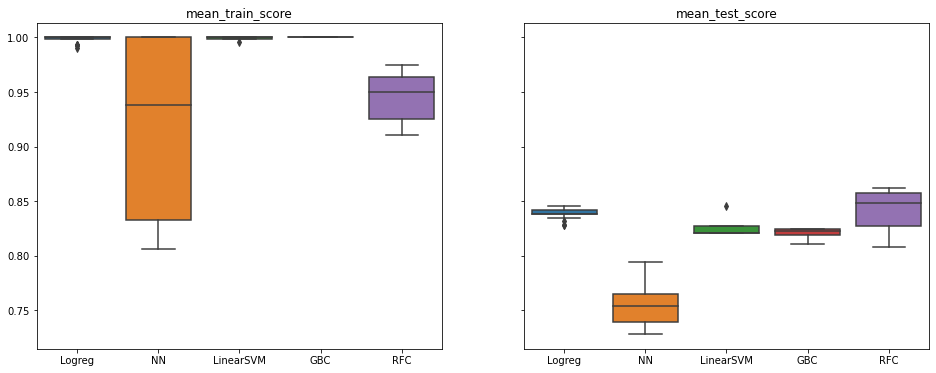

In [194]:
df_results = {}

for estimator in dict_classifiers:
    df_results[estimator] = pd.DataFrame(model_grid[estimator].cv_results_)


fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 6))    

index = -1

for metric in ["mean_train_score", "mean_test_score"]:
    index = index + 1
    
    data = [df_results[name][metric] for name, val in dict_classifiers.items()]
    
    sns.boxplot(data=data, ax=axs[index])
    axs[index].set_title(metric)
    axs[index].set_xticks(range(len(data)))
    axs[index].set_xticklabels([name for name, val in dict_classifiers.items()])

plt.show()

To get all the details from the _GridSearchCV_ run, there are following dataframes for inspection:
* `df_results["Logreg"]`
* `df_results["NN"]`
* `df_results["LinearSVM"]`
* `df_results["GBC"]`
* `df_results["RFC"]`

Here are results for the best model we found:

In [213]:
df_results["RFC"]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__criterion,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.226185,0.002375,0.026687,0.001417,gini,3,100,"{'randomforestclassifier__criterion': 'gini', ...",0.779661,0.810345,...,0.807656,0.021871,6,0.918103,0.905579,0.892704,0.909871,0.927039,0.910659,0.011598
1,0.259187,0.021604,0.032058,0.006164,gini,5,100,"{'randomforestclassifier__criterion': 'gini', ...",0.864407,0.844828,...,0.845295,0.027027,4,0.939655,0.957082,0.944206,0.961373,0.961373,0.952738,0.009077
2,0.282073,0.012693,0.032104,0.006608,gini,7,100,"{'randomforestclassifier__criterion': 'gini', ...",0.847458,0.879310,...,0.859147,0.027342,2,0.974138,0.961373,0.961373,0.969957,0.969957,0.967360,0.005121
3,0.238406,0.008570,0.027371,0.000387,entropy,3,100,{'randomforestclassifier__criterion': 'entropy...,0.830508,0.827586,...,0.821274,0.032125,5,0.952586,0.922747,0.888412,0.909871,0.914163,0.917556,0.020852
4,0.267096,0.019903,0.029175,0.002771,entropy,5,100,{'randomforestclassifier__criterion': 'entropy...,0.847458,0.862069,...,0.862595,0.024031,1,0.969828,0.935622,0.939914,0.948498,0.944206,0.947614,0.011907
5,0.294595,0.029602,0.039277,0.022566,entropy,7,100,{'randomforestclassifier__criterion': 'entropy...,0.847458,0.862069,...,0.852250,0.017407,3,0.982759,0.969957,0.982833,0.965665,0.974249,0.975092,0.006850


In [227]:
for estimator in dict_classifiers:
    std_test_score  = round(df_results[estimator][df_results[estimator]["rank_test_score"]==1]["std_test_score"] * 100, 2)
    mean_test_score = round(df_results[estimator][df_results[estimator]["rank_test_score"]==1]["mean_test_score"] * 100, 2)
    
    print(f"Best {estimator} model mean accuracy was {mean_test_score}% ±{std_test_score}%")



Best Logreg model mean accuracy was 5    84.53
6    84.53
8    84.53
Name: mean_test_score, dtype: float64% ±5    3.11
6    3.11
8    3.11
Name: std_test_score, dtype: float64%
Best NN model mean accuracy was 9    79.39
Name: mean_test_score, dtype: float64% ±9    4.44
Name: std_test_score, dtype: float64%
Best LinearSVM model mean accuracy was 0    84.54
Name: mean_test_score, dtype: float64% ±0    1.89
Name: std_test_score, dtype: float64%
Best GBC model mean accuracy was 2    82.47
3    82.47
Name: mean_test_score, dtype: float64% ±2    4.31
3    3.38
Name: std_test_score, dtype: float64%
Best RFC model mean accuracy was 4    86.26
Name: mean_test_score, dtype: float64% ±4    2.4
Name: std_test_score, dtype: float64%


# Summary

The best performing classifier model we trained was __RandomForestClassifier()__ with following parameters:
```
{
    'randomforestclassifier__criterion': 'entropy',
    'randomforestclassifier__max_depth': 5,
    'randomforestclassifier__n_estimators': 100
    }
```

__Accuracy__ = 86.26% ± 2.4%

## Some guessing game

In [172]:
def guess_artist(lyrics):
    
    #print(lyrics)
    
    words_list = nltk.word_tokenize(lyrics)
    # print(words_list)
    words_list = remove_punct(words_list)
    # print(words_list)
    words_list = to_lowercase(words_list)
    # print(words_list)
    words_list = remove_stopwords(words_list)
    # print(words_list)
    lyrics = " ".join(words_list)
    
    print("=====")
    
    for model_name, model_instantiation in dict_classifiers.items():
        print(f"{model_name} says it's: {model_grid[model_name].predict([lyrics])[0]}!")
    

    

In [175]:
question = input("Copy and paste some lyrics here:\n")

guess_artist(question)

Copy and paste some lyrics here:
mom's spagetti in the kitchen
=====
Logreg says it's: Queen!
NN says it's: Eminem!
LinearSVM says it's: Queen!
GBC says it's: Queen!
RFC says it's: Queen!
